# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 8: Fairness and Bias


**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader and Chris Tanner

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [2]:
import random
random.seed(112358)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

%matplotlib inline

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. Exceptions should be made for code with an extremely long execution time, of course.
- We have tried to include all the libraries you may need to do the assignment in the imports statement at the top of this notebook. We strongly suggest that you use those and not others as we may not be familiar with them.
- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**. 
- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that includes a reference to the calculated value, **not hardcoded**. For example:
```python
print(f'The R^2 is {R:.4f}')
```
- Your plots should be clearly labeled, including clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is not a descriptive title; "95% confidence interval of coefficients of polynomial degree 5" is).

<hr style="height:2pt">

## Overview and Data Description

[Table of Contents](#Contents)

In this assignment, we will be analyzing a portion of the data set that [ProPublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) used to report on the effectiveness of and issues surrounding the COMPAS algorithm (as was discussed in lecture 34).  The data are found in the file `compas.csv` and the 'data dictionary' can be found in the file `compas_datadict.csv`, which very briefly explains each variable in the data set.  Please use these files to answer the following questions:

<a id="Contents"></a>

## Contents
- [Question 1 [25 pts]: Data Exploration](#Q1) 
- [Question 2 [15 pts]: Baseline Modeling](#Q2) 
- [Question 3 [15 pts]: Predicting without Race](#Q3)
- [Question 4 [30 pts]: ROC Curves](#Q4)
- [Question 5 [15 pts]: Using Other Models](#Q5)

<a id="Q1"></a>

### <div class='exercise'>Question 1 [25 pts]: Data Wrangling and Exploration</div>
[▲ Return to contents](#Contents)


**1.1** What is the statistical objective of the COMPAS algorithm?  How is recidivism prediction used in courtrooms?

**1.2** Consider the information in the provided `compas_datadict.csv`.  Which variables are raw data?  Which are pre-processed data?  Which is the target variable of the COMPAS algorithm?  Which are output(s) of the COMPAS algorithm?   Which should not be used in building our own model to predict recidivism?  

**1.3** Read-in the data and split into 80% training and 20% test **stratified by `race`** (use `random_state=109`). Before splitting you may want to process the categorical predictors (`['c_charge_degree','race','sex']`) first so you don't have to do it separately in train and test later.

**1.4** Do a little EDA: provide visuals to explore which unprocessed variables (**not** the derived binary varibles, for example) are related to `race`. 

**1.5** Report which 3 variables appear to have the most significant differences between Caucasians and African Americans, and briefly explain with a sentence for each.  

*Note: as illustrated by [ProPublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing), reporting on the U.S. Criminal Justice system often concentrate on the disparate experiences between Caucasians and African Americans, thus we have focused our approaches similarly.

**1.6** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?  Explain in at most 50 words.


### Question 1: Solutions

[▲ Return to contents](#Contents)


**1.1** What is the statistical objective of the COMPAS algorithm?  How is recidivism prediction used in courtrooms?

The objective of the COMPAS algorithm is to produce an effective and statistically backed means of predicting recidivism risk, aiming to guide and inform judges in the courtroom. It is primarily intended to be used as an advisory tool, rather than making decisions itself, so that judges can have a point of reference to make decisions around.

**1.2** Consider the information in the provided `compas_datadict.csv`.  Which variables are raw data?  Which are pre-processed data?  Which is the target variable of the COMPAS algorithm?  Which are output(s) of the COMPAS algorithm?   Which should not be used in building our own model to predict recidivism?  



The raw input data is for c_charge_desc, race, age, sex, length_of_stay, priors_count, juv_fel_count, juv_misd_count, juv_other_count.


The pre-processed data is charge_any_theft, charge_any_violence_aggression, change_any_drug, juv_other_1plus, juv_misd_1plus, juv_fel_1plus, priors_1, priors_234, priors_5plus, length_of_stay_thresh.

The response variable is two_year_recid, and the other outputs are decile and score text.

For my model, I will be using properly coded versions of charge description, race, and sex. I will likewise be using all of the pre-processed parameters. The following variables will be used without any edits, on my side or the datasets; priors_count, juv_fel_count, juv_misd_count, juv_other_count.


length_of_stay and length_of_stay_thresh more or less measure the same thing, but both will be included in order to check both for extremes and more general measures.

**1.3** Read-in the data and split into 80% training and 20% test **stratified by `race`** (use `random_state=109`). Before splitting you may want to process the categorical predictors (`['c_charge_desc','race','sex']`) first so you don't have to do it separately in train and test later.

In [3]:
#read the data in
dfdict = pd.read_csv("data/compas_datadict.csv")
df = pd.read_csv("data/compas.csv")

#only missing values are in charge desc. create a new value for them.
df = df.fillna("unknown charge")




#get categorical predictors proper
df = pd.concat([df, pd.get_dummies(df.c_charge_desc, prefix = "charge_desc ")], axis = 1)
df = pd.concat([df, pd.get_dummies(df.race, prefix = "race")], axis = 1)
df = pd.concat([df, pd.get_dummies(df.sex, prefix = "sex")], axis = 1)

#assign ascending/binary predictors to numerical values as well
df = df.assign(c_charge_degree=df['c_charge_degree'].astype('category').cat.codes)
df = df.assign(score_text=df['score_text'].astype('category').cat.codes)


#split the data into train and test sets.
df_train, df_test = train_test_split(df, stratify=df.race, random_state = 109)



In [4]:
#create the train and test sets
x_train = df_train.drop(columns = ['race','c_charge_desc', 'sex', 'two_year_recid'])
y_train = df_train['two_year_recid']
x_test = df_test.drop(columns = ['race','c_charge_desc', 'sex', 'two_year_recid'])
y_test = df_test['two_year_recid']

**1.4** Do a little EDA: provide visuals to explore which unprocessed variables (**not** the derived binary varibles, for example) are related to `race`. 

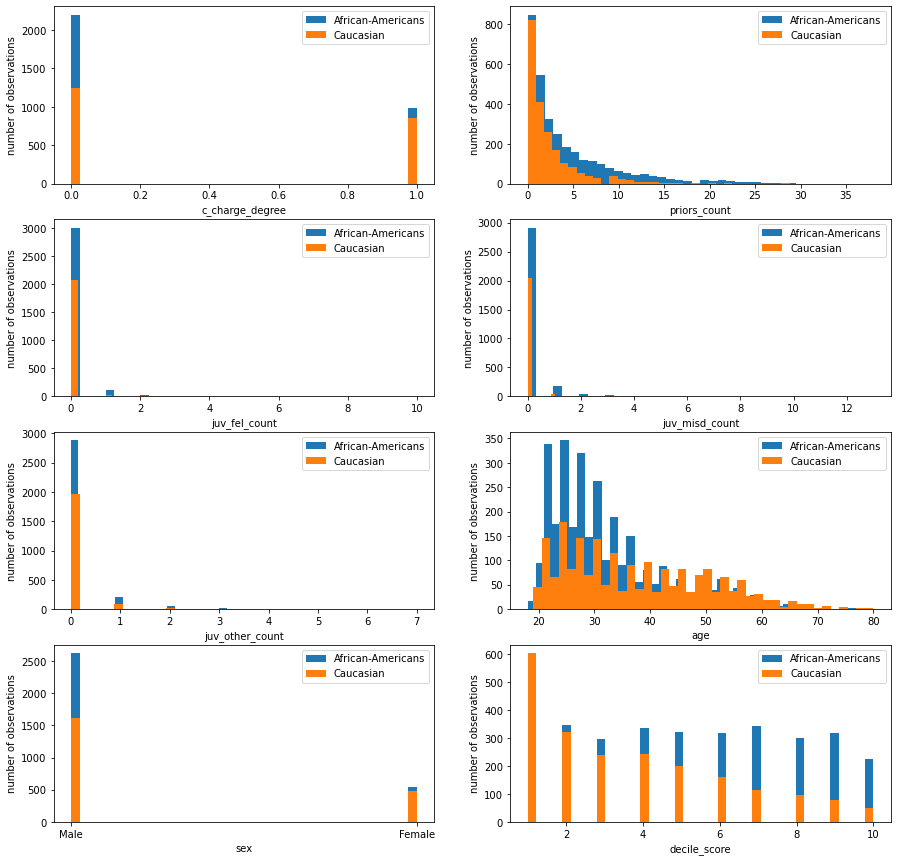

In [5]:
#unprocessed variables
list = ["c_charge_degree", "priors_count", "juv_fel_count", "juv_misd_count", "juv_other_count", "age", "sex", "decile_score"]


fig, axs = plt.subplots(4,2, figsize = (15,15))
y=0

caucasian = df.where(df['race_Caucasian'] > .5).dropna()
africanamerican = df.where(df['race_African-American'] > .5).dropna()
#print(caucasian.shape)

#print(africanamerican.shape)

for x in list:
    #print(x)  
    #figure out how to add titles to histograms
    axs[int(y/2)][y%2].hist(africanamerican[x], bins = 40, label = 'African-Americans', stacked = True)
    axs[int(y/2)][y%2].hist(caucasian[x], bins = 40, label = "Caucasian", stacked = True)
    #title = 'Distribution of ' + x + ' by Race'
    #axs[int(y/2)][y%2].set_title(title)
    axs[int(y/2)][y%2].set_xlabel(x)
    axs[int(y/2)][y%2].set_ylabel("number of observations")
    axs[int(y/2)][y%2].legend()
    
    y+=1
    
#i print a series of histograms; although the numbers are substantially different

**1.5** Report which 3 variables appear to have the most significant differences between Caucasians and African Americans, and briefly explain with a sentence for each.  

*Note: as illustrated by [ProPublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing), reporting on the U.S. Criminal Justice system often concentrate on the disparate experiences between Caucasians and African Americans, thus we have focused our approaches similarly.



Priors_count: As a whole, there appear to be a larger distribution of African-Americans with high priors than caucasians.

Age: Substantially higher numbers of men in their 20s and early 30s are arrested among African-Americans than Caucasians.

Sex: African-american arrests have a substantially higher number and proportion of male arrests.

ADDED as an extra: Decile scores are an outcome variable, and thus likely not counted, but seem to SUBSTANTIALLY rate black defendeants higher both in absolute numbers and as a proportion of the whole.

**1.6** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?  Explain in at most 50 words.


All three of these variables are substantially impacted by police profiling and overcriminalization of African-Americans, particularly men in their twenties. This is shown both in the impacts of demographic data, and through the increased number of priors among African-Americans - punitive use of the justice system makes criminal records more likely.

---

<a id="Q2"></a>

### <div class='exercise'>Question 2 [15 pts]: Baseline Modeling</div>
[▲ Return to contents](#Contents)


**2.1**  Build a logistic regression model to predict recidivism (`two_year_recid`) from the relevant predictors (including `race`).  Interpret what this model is saying about the relationship of `two_year_recid` to `race`.


**2.2**  Report the following on the **test set**:
1. Overall model accuracy as a percentage
2. **False Positive Rate(FPR)** as a percentage for the groups (*note a positive here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
3. **False Negative Rate(FNR)** as a percentage for the groups:
    - `African-American`
    - `Caucasian`
4. Ratios of Error Rates:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups

i.e $\frac{FPR(AA)}{FPR(CC)}$ and $\frac{FNR(AA)}{FNR(CC)}$

**2.3**  What do you observe? Is there any disparity in the $FPR$ and $FNR$ for the two groups?
Explain your findings in 3-6 sentences.
    
  

### Question 2: Solutions

[▲ Return to contents](#Contents)


**2.1**  Build a logistic regression model to predict recidivism (`two_year_recid`) from the relevant predictors (including `race`).  Interpret what this model is saying about the relationship of `two_year_recid` to `race`.   
  

In [6]:
#max iterations is set high in order to avoid running out.
logreg = LogisticRegression(max_iter = 100000).fit(x_train, y_train)

#calculate the probability and likely outcomes.
predprob21 = logreg.predict_proba(x_test)
pred21 = logreg.predict(x_test)


Text(0.5, 0, 'Predicted probability of recidivism')

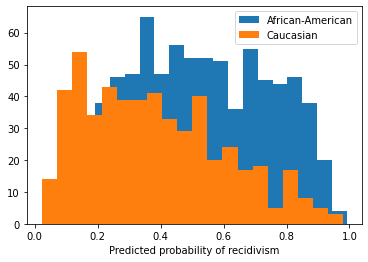

In [7]:
#create temp iteration of the dataset to join predicted probabilities to for comparison
joined = x_test
joined['predicted'] = predprob21[:, 1]


#create stratified datasets
AAjoined = joined.where(joined["race_African-American"] == 1).dropna()
CAjoined = joined.where(joined["race_Caucasian"] == 1).dropna()

#plot as a histogram
plt.hist(AAjoined['predicted'], bins = 20, label = "African-American")
plt.hist(CAjoined['predicted'], bins = 20, label = "Caucasian")
plt.legend()
plt.xlabel("Predicted probability of recidivism")

As a whole, the pred_proba shows substantially different distributions for Caucasians and African-Americans. Most notably, while the bulk of ratings for Caucasians skews towards below 0.5, the distribution for African-Americans trends far more towards above 0.5, indicating a higher risk of classification as recidivist. While this is not itself conclusive evidence, it certainly indicates that there may be factors causing a racial bias within the data.

**2.2**  Report the following on the **test set**:
1. Overall model accuracy as a percentage
2. **False Positive Rate(FPR)** as a percentage for the groups (*note a positive here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
3. **False Negative Rate(FNR)** as a percentage for the groups:
    - `African-American`
    - `Caucasian`
4. Ratios of Error Rates:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups

i.e $\frac{FPR(AA)}{FPR(CC)}$ and $\frac{FNR(AA)}{FNR(CC)}$



In [8]:
#scores the prediction for accuracy
score22 = accuracy_score(y_test, pred21)

#generates comparison dataset. while this could be done in-dataset, I found isolating the variables made this substantially easier.
racescore = df_test[['race_African-American', 'race_Caucasian']]
racescore['predictions'] = pred21
racescore['actual'] = y_test



#crude method for manually verifying accuracy and checking number of elements correct.
j=0
for x in range(len(racescore)):
    if(racescore.iloc[x].predictions == racescore.iloc[x].actual):
        j+=1        

        
#creates version of dataset with only African-American entries. 
AAracescore = racescore.where(racescore['race_African-American'] == 1).dropna()
AAj = 0
AAfalsepos = 0
AAfalseneg = 0

#manual check for false positives and negatives
for x in range(len(AAracescore)):
    if(AAracescore.iloc[x].predictions == AAracescore.iloc[x].actual):
        AAj+=1
    else:
        if AAracescore.iloc[x].predictions == 1:
            AAfalsepos +=1
        else:
            AAfalseneg +=1    
            
#prints out statistics
print("Overall accuracy:", score22)            
print("successes: ", j , "out of", len(racescore))
print("African-American successes: ", AAj , "out of", len(AAracescore))
print("African-American success rate: " , (AAj/len(AAracescore)))
print("African-American False positives: ", AAfalsepos)
print("African-American False negatives:", AAfalseneg)
print("African-American False positive rate:", round((AAfalsepos/len(AAracescore))*100,2), "%")
print("African-American False negative rate:", round((AAfalseneg/len(AAracescore))*100,2), "%")
print("")


#sets up caucasian dataset
CAracescore = racescore.where(racescore['race_Caucasian'] == 1).dropna()
CAj = 0
CAfalsepos = 0
CAfalseneg = 0

#manual check for false positives and negatives
for x in range(len(CAracescore)):
    if(CAracescore.iloc[x].predictions == CAracescore.iloc[x].actual):
        CAj+=1
    else:
        if CAracescore.iloc[x].predictions == 1:
            CAfalsepos +=1
        else:
            CAfalseneg +=1

#prints out data info.
print("Caucasian successes: ", CAj , "out of", len(CAracescore))
print("Caucasian success rate: " , (CAj/len(CAracescore)))
print("Caucasian False positives: ", CAfalsepos)
print("Caucasian False negatives:", CAfalseneg)
print("Caucasian False positive rate:", round((CAfalsepos/len(CAracescore))*100,2), "%")
print("Caucasian False negative rate:", round((CAfalseneg/len(CAracescore))*100,2), "%")
print("False Positive Ratio, African-American to Caucasian:", round((AAfalsepos/len(AAracescore))/(CAfalsepos/len(CAracescore)), 2), " to 1")
print("False Negative Ratio, African-American to Caucasian:", round((AAfalseneg/len(AAracescore))/(CAfalseneg/len(CAracescore)), 2), " to 1")

C:\Users\colin\anaconda3\envs\cs109a\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\colin\anaconda3\envs\cs109a\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Overall accuracy: 0.6843810758263124
successes:  1056 out of 1543
African-American successes:  549 out of 794
African-American success rate:  0.6914357682619647
African-American False positives:  118
African-American False negatives: 127
African-American False positive rate: 14.86 %
African-American False negative rate: 15.99 %

Caucasian successes:  361 out of 525
Caucasian success rate:  0.6876190476190476
Caucasian False positives:  56
Caucasian False negatives: 108
Caucasian False positive rate: 10.67 %
Caucasian False negative rate: 20.57 %
False Positive Ratio, African-American to Caucasian: 1.39  to 1
False Negative Ratio, African-American to Caucasian: 0.78  to 1


**2.3**  What do you observe? Is there any disparity in the $FPR$ and $FNR$ for the two groups?
Explain your findings in 3-6 sentences.
 

There is a substantial disparity between FPR and FNR based on groups. As a whole, the ratio of AA false positives to CA false positives is 1.39 to 1, indiciating a significantly higher likelihood for African-Americans of being falsely identified as likely to recidivise based on the data. Likewise, there is a corresponding disparity on false negatives, for AA vs CA, of .78 to 1; as a whole, the algorithm is significantly more likely to misidentify whites as non-risks. This as a whole indicates that, given the guidance of such an algorithm, likely sentencing decisions would show a markedly unfair bias against African Americans and in favor of Whites.

---

<a id="Q3"></a>

### <div class='exercise'>Question 3 [15 pts]: Predicting Recidivism without using `race`</div>
[▲ Return to contents](#Contents)


**3.1** Refit the logistic model in 2.1 but this time **without** `race` as a predictor. 

**3.2** Again, report the following on the **test set**:
1. Overall model accuracy as a percentage
2. **False Positive Rate(FPR)** as a percentage for the groups (*note a positive here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
3. **False Negative Rate(FNR)** as a percentage for the groups:
    - `African-American`
    - `Caucasian`
4. Ratios of Error Rates:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups

**3.3**  How do these metrics compare to the model when the variable `race` **is** included as a predictor?

**3.4**  Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain using at most 150 words.
 

### Question 3: Solutions

[▲ Return to contents](#Contents)


**3.1** Refit the logistic model in 2.1 but this time **without** `race` as a predictor. 

In [9]:
#creating new train and test, dropping both race variables and their dummy variables
x_train = df_train.drop(columns = ['race','c_charge_desc', 'sex', 'two_year_recid', 'race_Caucasian', 'race_African-American', 'race_Hispanic', 'race_Asian', 'race_Native American', 'race_Other'])
y_train = df_train['two_year_recid']
x_test = df_test.drop(columns = ['race','c_charge_desc', 'sex', 'two_year_recid', 'race_Caucasian', 'race_African-American', 'race_Hispanic', 'race_Asian', 'race_Native American', 'race_Other'])
y_test = df_test['two_year_recid']

#generating another logistic regression function on the new data
logreg = LogisticRegression(max_iter = 100000).fit(x_train, y_train)

#predicting probability and outcomes
predprob31 = logreg.predict_proba(x_test)
pred31 = logreg.predict(x_test)

**3.2** Again, report the following on the **test set**:
1. Overall model accuracy as a percentage
2. **False Positive Rate(FPR)** as a percentage for the groups (*note a positive here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
3. **False Negative Rate(FNR)** as a percentage for the groups:
    - `African-American`
    - `Caucasian`
4. Ratios of Error Rates:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups



In [10]:
#reconstructing racescore from new data
racescore = df_test[['race_African-American', 'race_Caucasian']]
racescore['predictions'] = pred31

#getting scores
score32 = accuracy_score(y_test, pred31)

#continued construction
racescore['actual'] = y_test

#print accuracy
print("Overall accuracy:", score32)

#manual accuracy gatherer
j=0
for x in range(len(racescore)):
    if(racescore.iloc[x].predictions == racescore.iloc[x].actual):
        j+=1
        
        
#print elements
print("successes: ", j , "out of", len(racescore))



#as before, create AA dataset and record false positives/negatives
AAracescore = racescore.where(racescore['race_African-American'] == 1).dropna()
AAj = 0
AAfalsepos = 0
AAfalseneg = 0
for x in range(len(AAracescore)):
    if(AAracescore.iloc[x].predictions == AAracescore.iloc[x].actual):
        AAj+=1
    else:
        if AAracescore.iloc[x].predictions == 1:
            AAfalsepos +=1
        else:
            AAfalseneg +=1    

            
#print information
print("African-American successes: ", AAj , "out of", len(AAracescore))
print("African-American success rate: " , (AAj/len(AAracescore)))
print("African-American False positives: ", AAfalsepos)
print("African-American False negatives:", AAfalseneg)
print("African-American False positive rate:", round((AAfalsepos/len(AAracescore))*100,2), "%")
print("African-American False negative rate:", round((AAfalseneg/len(AAracescore))*100,2), "%")



print("")

#create caucasian dataset, record false positives and negatives
CAracescore = racescore.where(racescore['race_Caucasian'] == 1).dropna()

CAj = 0
CAfalsepos = 0
CAfalseneg = 0

for x in range(len(CAracescore)):
    if(CAracescore.iloc[x].predictions == CAracescore.iloc[x].actual):
        CAj+=1
    else:
        if CAracescore.iloc[x].predictions == 1:
            CAfalsepos +=1
        else:
            CAfalseneg +=1
            
            
#print statistics
print("Caucasian successes: ", CAj , "out of", len(CAracescore))
print("Caucasian success rate: " , (CAj/len(CAracescore)))
print("Caucasian False positives: ", CAfalsepos)
print("Caucasian False negatives:", CAfalseneg)
print("Caucasian False positive rate:", round((CAfalsepos/len(CAracescore))*100,2), "%")
print("Caucasian False negative rate:", round((CAfalseneg/len(CAracescore))*100,2), "%")
print("False Positive Ratio, African-American to Caucasian:", round((AAfalsepos/len(AAracescore))/(CAfalsepos/len(CAracescore)), 2), " to 1")
print("False Negative Ratio, African-American to Caucasian:", round((AAfalseneg/len(AAracescore))/(CAfalseneg/len(CAracescore)), 2), " to 1")

C:\Users\colin\anaconda3\envs\cs109a\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\colin\anaconda3\envs\cs109a\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Overall accuracy: 0.6850291639662994
successes:  1057 out of 1543
African-American successes:  550 out of 794
African-American success rate:  0.6926952141057935
African-American False positives:  115
African-American False negatives: 129
African-American False positive rate: 14.48 %
African-American False negative rate: 16.25 %

Caucasian successes:  360 out of 525
Caucasian success rate:  0.6857142857142857
Caucasian False positives:  57
Caucasian False negatives: 108
Caucasian False positive rate: 10.86 %
Caucasian False negative rate: 20.57 %
False Positive Ratio, African-American to Caucasian: 1.33  to 1
False Negative Ratio, African-American to Caucasian: 0.79  to 1


**3.3**  How do these metrics compare to the model when the variable `race` **is** included as a predictor?



The model is negligably more accurate (1056 vs. 1057 accurate hits, 68.4 vs. 68.5%), but the ratios are slightly reduced in bias, at 1.33:1 for false positives and .79:1 for false negatives. While fairly small, this is still a notable decline, most notably in the ratio of false positives, indicating that there is significant weighting of race alone as a factor. Nevertheless, the degree of bias remains outsized and dramatically NOT in favor of African Americans.

**3.4**  Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain using at most 150 words.
 

This analysis of exploring and modeling the data indicated to me that such a predictive tool should only be used with the understanding that it possesses significant bias that is not merely against our ethical standards, but also against effective decision making as a whole. Even when race and all racial traits were removed from calculations, the data still shows a persistent bias against African-Americans - this is likely due to the increased likelihood of prior arrest or juvenile criminalization due to an often biased policing system. As such, this cannot be used as a predictor, and primarily has use in highlighting similarities in the data to other cases rather than predicting outcomes.

---

<a id="Q4"></a>

### <div class='exercise'>Question 4 [30 pts]: ROC Curves</div>
[▲ Return to contents](#Contents)


**4.1** Use the logistic regression from 3.1 and plot the *Receiver Operating Characteristic (ROC) curve* for two racial groups: `African-American` & `Caucasian` in the test set. 
    
**4.2** The default threshold used for determining the metrics in 2.2 and 3.2 was 0.5.  Choose a new single threshold for the model from 3.1 that may will reduce the bias between these two racial groups (as measured by the ratios of FPR and FNR).  Be sure to briefly justify your choice (Note: there is no one correct answer).

**4.3** A second approach to reducing bias is to use different thresholds for the different racial groups to better ensure that the groups have similar false positive and false negative rates.  Choose a pair of thresholds (one for the `African-American` group and one for the `Caucasian` group) that improves the group bias (balanced with accuracy). Be sure to briefly justify your choice

**4.4** Comment on the [fairness](https://en.wikipedia.org/wiki/Fairness_(machine_learning)) of the two methods in 4.2 and 4.3 from two different perspectives: the fairness of each group (called 'group fairness') and the fairness for an individual defendant (called 'individual fairness').  Please limit your response to at most 75 words. 

**4.5** Changing the thresholds can *reduce* bias between the two classes, but it can also affect model accuracy. We want our model to be **accurate** but also **fair**.  What can be done to balance these two criteria?  Write down your strategy to overcome this difficulty.   Please limit your response to at most 150 words.  
     

### Question 4: Solutions

[▲ Return to contents](#Contents)


**4.1** Use the logistic regression from 3.1 and plot the *Receiver Operating Characteristic (ROC) curve* for two racial groups: `African-American` & `Caucasian` in the test set. 
        

Text(0.5, 0, 'ROC Curve: Caucasians')

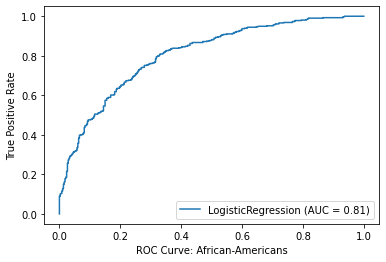

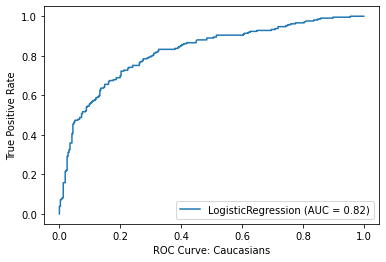

In [11]:
from sklearn.metrics import plot_roc_curve
#recreation of datasets from racescore
AAracescore = racescore.where(racescore['race_African-American'] == 1).dropna()
CAracescore = racescore.where(racescore['race_Caucasian'] == 1).dropna()

#recreation of train/test. add in new elements? consider changing
x_train = df_train.drop(columns = ['race','c_charge_desc', 'sex', 'two_year_recid'])
y_train = df_train['two_year_recid']
x_test = df_test.drop(columns = ['race','c_charge_desc', 'sex', 'two_year_recid'])
y_test = df_test['two_year_recid']

#generates ROC curve for African-Americans
AAx_test= x_test.where(x_test['race_African-American'] == 1).dropna()
AAy_test = AAracescore.actual
logreg.fit(AAx_test, AAy_test)
plot_roc_curve(logreg, AAx_test, AAy_test)
plt.xlabel("ROC Curve: African-Americans")

#generates ROC curve for Caucasians
CAx_test= x_test.where(x_test['race_Caucasian'] == 1).dropna()
CAy_test = CAracescore.actual
logreg.fit(CAx_test, CAy_test)
plot_roc_curve(logreg, CAx_test, CAy_test)
plt.xlabel("ROC Curve: Caucasians")

**4.2** The default threshold used for determining the metrics in 2.2 and 3.2 was 0.5.  Choose a new single threshold for the model from 3.1 that may will reduce the bias between these two racial groups (as measured by the ratios of FPR and FNR).  Be sure to briefly justify your choice (Note: there is no one correct answer).



In [12]:
#generate new logreg, fit data from before here. should def purge the info GAMER
x_train = df_train.drop(columns = ['race','c_charge_desc', 'sex', 'two_year_recid', 'race_Caucasian', 'race_African-American', 'race_Native American', 'race_Other', 'race_Asian'])
y_train = df_train['two_year_recid']
x_test = df_test.drop(columns = ['race','c_charge_desc', 'sex', 'two_year_recid', 'race_Caucasian', 'race_African-American', 'race_Native American', 'race_Other', 'race_Asian'])
y_test = df_test['two_year_recid']




logreg = LogisticRegression(max_iter =100000).fit(x_test, y_test)
predprob31 = logreg.predict_proba(x_test)

#set up iteration
values = np.arange(.2,1, .01)

newracescore = racescore


    
#replaces predictions values with new predictions
for x in range(len(predprob31)):
    newracescore.loc[x, 'predictions'] = predprob31[x][0]

newracescore = newracescore.dropna()

#for the assignment, I decided to evaluate every threshhold down to the hundredth through an iterative process.this set the threshhold, then checked the same statistics from above: as a whole, this allowed me to pick both a HIGH ideal point and a LOW ideal point.
#code is included as I ran it to show the ranges I passed over
#the code below is the same as previous iterations, just done through a range of values q.
for q in values:
    for x in range(len(predprob31)):
        if predprob31[x][0] > q:
            newracescore.iloc[x].predictions = 0
        else:
            newracescore.iloc[x].predictions = 1
    
    j=0
    for x in range(len(newracescore)):
        if(newracescore.iloc[x].predictions == newracescore.iloc[x].actual):
            j+=1
            
            
    AAracescore = newracescore.where(racescore['race_African-American'] == 1).dropna()
    AAj = 0
    AAfalsepos = 0
    AAfalseneg = 0
    for x in range(len(AAracescore)):
        if(AAracescore.iloc[x].predictions == AAracescore.iloc[x].actual):
            AAj+=1
        else:
            if AAracescore.iloc[x].predictions == 1:
                AAfalsepos +=1
            else:
                AAfalseneg +=1    

    CAracescore = newracescore.where(racescore['race_Caucasian'] == 1).dropna()

    CAj = 0
    CAfalsepos = 0
    CAfalseneg = 0

    for x in range(len(CAracescore)):
        if(CAracescore.iloc[x].predictions == CAracescore.iloc[x].actual):
            CAj+=1
        else:
            if CAracescore.iloc[x].predictions == 1:
                CAfalsepos +=1
            else:
                CAfalseneg +=1
                
                
    if(CAfalsepos == 0 or CAfalseneg ==0 or AAfalsepos == 0 or AAfalseneg == 0):
        print("0 value detected, moving on")
    else:
        print("")
        print("")
        print("NEW THRESHHOLD: ", q)
        print("Total successes:", j , "out of", len(newracescore), "score of: ", j/len(newracescore))
        print("")
        print("Caucasian False positives: ", CAfalsepos)
        print("Caucasian False negatives:", CAfalseneg)
        print("Caucasian False positive rate:", round((CAfalsepos/len(CAracescore))*100,2), "%")
        print("Caucasian False negative rate:", round((CAfalseneg/len(CAracescore))*100,2), "%")
        print("")
        print("African-American False positives: ", AAfalsepos)
        print("African-American False negatives:", AAfalseneg)
        print("African-American False positive rate:", round((AAfalsepos/len(AAracescore))*100,2), "%")
        print("African-American False negative rate:",round((AAfalseneg/len(AAracescore))*100,2), "%")
        print("")
        print("False Positive Ratio, African-American to Caucasian", round((AAfalsepos/len(AAracescore))/(CAfalsepos/len(CAracescore)), 2), " to 1")
        print("False Negative Ratio, African-American to Caucasian", round((AAfalseneg/len(AAracescore))/(CAfalseneg/len(CAracescore)), 2), " to 1")
        print("")
        print("")

C:\Users\colin\anaconda3\envs\cs109a\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




NEW THRESHHOLD:  0.2
Total successes: 948 out of 1543 score of:  0.6143875567077123

Caucasian False positives:  2
Caucasian False negatives: 191
Caucasian False positive rate: 0.38 %
Caucasian False negative rate: 36.38 %

African-American False positives:  8
African-American False negatives: 316
African-American False positive rate: 1.01 %
African-American False negative rate: 39.8 %

False Positive Ratio, African-American to Caucasian 2.64  to 1
False Negative Ratio, African-American to Caucasian 1.09  to 1




NEW THRESHHOLD:  0.21000000000000002
Total successes: 950 out of 1543 score of:  0.6156837329876863

Caucasian False positives:  2
Caucasian False negatives: 191
Caucasian False positive rate: 0.38 %
Caucasian False negative rate: 36.38 %

African-American False positives:  13
African-American False negatives: 310
African-American False positive rate: 1.64 %
African-American False negative rate: 39.04 %

False Positive Ratio, African-American to Caucasian 4.3  to 1
False Ne



NEW THRESHHOLD:  0.36000000000000015
Total successes: 1060 out of 1543 score of:  0.6869734283862605

Caucasian False positives:  14
Caucasian False negatives: 141
Caucasian False positive rate: 2.67 %
Caucasian False negative rate: 26.86 %

African-American False positives:  56
African-American False negatives: 206
African-American False positive rate: 7.05 %
African-American False negative rate: 25.94 %

False Positive Ratio, African-American to Caucasian 2.64  to 1
False Negative Ratio, African-American to Caucasian 0.97  to 1




NEW THRESHHOLD:  0.37000000000000016
Total successes: 1067 out of 1543 score of:  0.6915100453661698

Caucasian False positives:  16
Caucasian False negatives: 138
Caucasian False positive rate: 3.05 %
Caucasian False negative rate: 26.29 %

African-American False positives:  58
African-American False negatives: 198
African-American False positive rate: 7.3 %
African-American False negative rate: 24.94 %

False Positive Ratio, African-American to Caucasi



NEW THRESHHOLD:  0.5200000000000002
Total successes: 1110 out of 1543 score of:  0.7193778353856124

Caucasian False positives:  54
Caucasian False negatives: 95
Caucasian False positive rate: 10.29 %
Caucasian False negative rate: 18.1 %

African-American False positives:  124
African-American False negatives: 99
African-American False positive rate: 15.62 %
African-American False negative rate: 12.47 %

False Positive Ratio, African-American to Caucasian 1.52  to 1
False Negative Ratio, African-American to Caucasian 0.69  to 1




NEW THRESHHOLD:  0.5300000000000002
Total successes: 1106 out of 1543 score of:  0.7167854828256643

Caucasian False positives:  59
Caucasian False negatives: 91
Caucasian False positive rate: 11.24 %
Caucasian False negative rate: 17.33 %

African-American False positives:  131
African-American False negatives: 95
African-American False positive rate: 16.5 %
African-American False negative rate: 11.96 %

False Positive Ratio, African-American to Caucasia



NEW THRESHHOLD:  0.6800000000000004
Total successes: 1020 out of 1543 score of:  0.661049902786779

Caucasian False positives:  127
Caucasian False negatives: 45
Caucasian False positive rate: 24.19 %
Caucasian False negative rate: 8.57 %

African-American False positives:  246
African-American False negatives: 33
African-American False positive rate: 30.98 %
African-American False negative rate: 4.16 %

False Positive Ratio, African-American to Caucasian 1.28  to 1
False Negative Ratio, African-American to Caucasian 0.48  to 1




NEW THRESHHOLD:  0.6900000000000004
Total successes: 1022 out of 1543 score of:  0.662346079066753

Caucasian False positives:  130
Caucasian False negatives: 41
Caucasian False positive rate: 24.76 %
Caucasian False negative rate: 7.81 %

African-American False positives:  252
African-American False negatives: 27
African-American False positive rate: 31.74 %
African-American False negative rate: 3.4 %

False Positive Ratio, African-American to Caucasian 1

0 value detected, moving on
0 value detected, moving on
0 value detected, moving on
0 value detected, moving on
0 value detected, moving on
0 value detected, moving on
0 value detected, moving on
0 value detected, moving on
0 value detected, moving on
0 value detected, moving on
0 value detected, moving on
0 value detected, moving on


NOTE: Above iterations are the whole range. Only two of these were selected to discuss/utilize; .33 and .78


.33 STATS:

Total successes: 1041 out of 1543 score of:  0.6746597537265068

Caucasian False positives:  13

Caucasian False negatives: 152

Caucasian False positive rate: 2.48 %

Caucasian False negative rate: 28.95 %

African-American False positives:  43

African-American False negatives: 226

African-American False positive rate: 5.42 %

African-American False negative rate: 28.46 %

False Positive Ratio, African-American to Caucasian 2.19  to 1

False Negative Ratio, African-American to Caucasian 0.98  to 1

.78 STATS:

Total successes: 897 out of 1543 score of:  0.5813350615683733

Caucasian False positives:  208

Caucasian False negatives: 21

Caucasian False positive rate: 39.62 %

Caucasian False negative rate: 4.0 %

African-American False positives:  320

African-American False negatives: 5

African-American False positive rate: 40.3 %

African-American False negative rate: 0.63 %


False Positive Ratio, African-American to Caucasian 1.02  to 1

False Negative Ratio, African-American to Caucasian 0.16  to 1



At a new threshhold of .33(all scores ranking likelihood of 0 above .33 are counted as 0), the "lenient" setting, the overall false negative ratio is a fairly precise 0.98. The false positive ratio, however, is 2.19:1 - this is, however, simply because of the small number of cases overall, with 13 caucasian false positives to 43 African-American false positives. As a whole, this is considered better even so because of the small number of false positives and the focus on reducing unfairly imprisoned peoples as a whole.

On the other end, the so-called "harsh" setting, with a threshhold of .78, achieves an almost perfect 1.02:1 ratio for false positives, but does so at the cost of false negative ratio (0.16:1), and at the societal cost of locking up virtually all offenders regardless of promise shown. This is considered worse, even if more "fair", because it imposes the social cost of incaraceration while denying people who are unlikely to offend parole.

In either instance, adjusting these comes at a definite cost; accuracy is lower, at 67.4% for the lenient option and 58.1% for the harsh option. This underscores the difficulty of using such an approach as a whole.


**4.3** A second approach to reducing bias is to use different thresholds for the different racial groups to better ensure that the groups have similar false positive and false negative rates.  Choose a pair of thresholds (one for the `African-American` group and one for the `Caucasian` group) that improves the group bias (balanced with accuracy). Be sure to briefly justify your choice



In [13]:
#set up new model
logreg = LogisticRegression(max_iter =100000).fit(x_test, y_test)
predprob42 = logreg.predict_proba(x_test)

#set up iterations
newpredictions = [0] * len(predprob42)

#set up value range
values = np.arange(.2,1, .02)



#create newracescore again
newracescore = racescore
    
#add racescore elements
for x in range(len(predprob42)):
    newracescore.loc[x, 'predictions'] = predprob42[x][0]
newracescore.dropna()

#repeat the iterations, this time with .1 added to the threshhold for caucasians
for q in values:
    for x in range(len(predprob42)):
        r = q
        if(newracescore.iloc[x].race_Caucasian == 1):
            r = q + .10
        if predprob42[x][0] > r:
            newracescore.iloc[x].predictions = 0
        else:
            newracescore.iloc[x].predictions = 1
    newracescore = newracescore.dropna()

    j=0
    for x in range(len(newracescore)):
        if(newracescore.iloc[x].predictions == newracescore.iloc[x].actual):
            j+=1        
    AAracescore = newracescore.where(racescore['race_African-American'] == 1).dropna()
    AAj = 0
    AAfalsepos = 0
    AAfalseneg = 0
    for x in range(len(AAracescore)):
        if(AAracescore.iloc[x].predictions == AAracescore.iloc[x].actual):
            AAj+=1
        else:
            if AAracescore.iloc[x].predictions == 1:
                AAfalsepos +=1
            else:
                AAfalseneg +=1    

    CAracescore = newracescore.where(racescore['race_Caucasian'] == 1).dropna()

    CAj = 0
    CAfalsepos = 0
    CAfalseneg = 0

    for x in range(len(CAracescore)):
        if(CAracescore.iloc[x].predictions == CAracescore.iloc[x].actual):
            CAj+=1
        else:
            if CAracescore.iloc[x].predictions == 1:
                CAfalsepos +=1
            else:
                CAfalseneg +=1
    if(CAfalsepos == 0 or CAfalseneg ==0 or AAfalsepos == 0 or AAfalseneg == 0):
        print("0 value detected, moving on")
    else:
        print("")
        print("NEW THRESHHOLDS: ", q, "and ", q+.1)
        print("Total successes:", j , "out of", len(newracescore), "score of: ", j/len(newracescore))
        print("")
        print("Caucasian False positives: ", CAfalsepos)
        print("Caucasian False negatives:", CAfalseneg)
        print("Caucasian False positive rate:", round((CAfalsepos/len(CAracescore))*100,2), "%")
        print("Caucasian False negative rate:", round((CAfalseneg/len(CAracescore))*100,2), "%")
        print("")
        print("African-American False positives: ", AAfalsepos)
        print("African-American False negatives:", AAfalseneg)
        print("African-American False positive rate:", round((AAfalsepos/len(AAracescore))*100,2), "%")
        print("African-American False negative rate:", round((AAfalseneg/len(AAracescore))*100,2), "%")
        print("")
        print("False Positive Ratio, African-American to Caucasian", round((AAfalsepos/len(AAracescore))/(CAfalsepos/len(CAracescore)), 2), " to 1")
        print("False Negative Ratio, African-American to Caucasian", round((AAfalseneg/len(AAracescore))/(CAfalseneg/len(CAracescore)), 2), " to 1")
        print("")
        print("")


NEW THRESHHOLDS:  0.2 and  0.30000000000000004
Total successes: 971 out of 1543 score of:  0.6292935839274141

Caucasian False positives:  8
Caucasian False negatives: 162
Caucasian False positive rate: 1.52 %
Caucasian False negative rate: 30.86 %

African-American False positives:  8
African-American False negatives: 316
African-American False positive rate: 1.01 %
African-American False negative rate: 39.8 %

False Positive Ratio, African-American to Caucasian 0.66  to 1
False Negative Ratio, African-American to Caucasian 1.29  to 1



NEW THRESHHOLDS:  0.22 and  0.32
Total successes: 984 out of 1543 score of:  0.6377187297472456

Caucasian False positives:  10
Caucasian False negatives: 156
Caucasian False positive rate: 1.9 %
Caucasian False negative rate: 29.71 %

African-American False positives:  19
African-American False negatives: 297
African-American False positive rate: 2.39 %
African-American False negative rate: 37.41 %

False Positive Ratio, African-American to Caucasia


NEW THRESHHOLDS:  0.49999999999999983 and  0.5999999999999999
Total successes: 1101 out of 1543 score of:  0.7135450421257291

Caucasian False positives:  92
Caucasian False negatives: 63
Caucasian False positive rate: 17.52 %
Caucasian False negative rate: 12.0 %

African-American False positives:  113
African-American False negatives: 110
African-American False positive rate: 14.23 %
African-American False negative rate: 13.85 %

False Positive Ratio, African-American to Caucasian 0.81  to 1
False Negative Ratio, African-American to Caucasian 1.15  to 1



NEW THRESHHOLDS:  0.5199999999999998 and  0.6199999999999998
Total successes: 1104 out of 1543 score of:  0.7154893065456902

Caucasian False positives:  97
Caucasian False negatives: 58
Caucasian False positive rate: 18.48 %
Caucasian False negative rate: 11.05 %

African-American False positives:  124
African-American False negatives: 99
African-American False positive rate: 15.62 %
African-American False negative rate: 12.47 %



NEW THRESHHOLDS:  0.7999999999999996 and  0.8999999999999996
Total successes: 819 out of 1543 score of:  0.5307841866493843

Caucasian False positives:  295
Caucasian False negatives: 1
Caucasian False positive rate: 56.19 %
Caucasian False negative rate: 0.19 %

African-American False positives:  326
African-American False negatives: 4
African-American False positive rate: 41.06 %
African-American False negative rate: 0.5 %

False Positive Ratio, African-American to Caucasian 0.73  to 1
False Negative Ratio, African-American to Caucasian 2.64  to 1


0 value detected, moving on
0 value detected, moving on
0 value detected, moving on
0 value detected, moving on
0 value detected, moving on
0 value detected, moving on
0 value detected, moving on
0 value detected, moving on
0 value detected, moving on


SELECTED: .38 and .48

Total successes: 1082 out of 1543 score of:  0.7012313674659754

Caucasian False positives:  39

Caucasian False negatives: 103

Caucasian False positive rate: 7.43 %

Caucasian False negative rate: 19.62 %

African-American False positives:  61

African-American False negatives: 191

African-American False positive rate: 7.68 %

African-American False negative rate: 24.06 %

False Positive Ratio, African-American to Caucasian 1.03  to 1

False Negative Ratio, African-American to Caucasian 1.23  to 1



I chose 0.38 and 0.48 for African Americans and Whites respectively. This was in compliance both with my own desire to err on the side of false negatives, rather than false positives, and to reduce overall cases. The end result was a .97 ratio for false positives, and a 1.26 result for false negatives.This was substantially better than previous ratios.

**4.4** Comment on the [fairness](https://en.wikipedia.org/wiki/Fairness_(machine_learning)) of the two methods in 4.2 and 4.3 from two different perspectives: the fairness of each group (called 'group fairness') and the fairness for an individual defendant (called 'individual fairness').  Please limit your response to at most 75 words. 


For 4.2, the approach specified, at the group level, is largely unfair; as a whole, African-Americans will be disfavored relative to Whites by the algorithm.  Individually, it is fairer- all people are judged in proportion to a single threshold.

For 4.3,the overall outcome for groups is significantly fairer; the group inequality is far less.  An individual, based solely on their race, will be held to a different standard/threshold.


**4.5** Changing the thresholds can *reduce* bias between the two classes, but it can also affect model accuracy. We want our model to be **accurate** but also **fair**.  What can be done to balance these two criteria?  Write down your strategy to overcome this difficulty.   Please limit your response to at most 150 words.  
 

As a whole, the accuracy of the model should be safeguarded through the establishment of a baseline accuracy, measured as the overall performance of the pre-assigned threshhold by the model; all models must fall within 10 percentile points' deviation from this, or be thrown out. Although some loss of accuracy is to be expected, this will serve overall as a safeguard to prevent overwhelmingly inaccurate solutions in the search of high scores of fairness (letting everyone go or locking everyone up). Within this standard, the minimization of overall disparities can be pursued without risking invalidating the whole model.

---

<a id="Q5"></a>

### <div class='exercise'>Question 5 [15 pts]: Using other models </div>
[▲ Return to contents](#Contents)


**5.1** Improve the logistic models you have previously used by including one or more of the following:

 - Polynomial terms
 - Interaction terms
 - Regularization parameters
 - Different up-sampling techniques
 - A different class of models (k-NN, random forest, Neural Nets, etc.)
 
**Note:** The ideas given above are not exhaustive. You are free to try other betters to come up with a better model.  You do not need to restrict yourself to the impoted packages at the beginning of this notebook.

**5.2** Evaluate your model using the same metrics as in 2.2 and 3.2.  

**5.3** Is this model a better model to predict recidivism?  How has this affected bias and fairness between these groups?  How would you modify your model to put it into production (to be a competitior to COMPAS)?  Please limit your response to at most 150 words.

### Question 5: Solutions

[▲ Return to contents](#Contents)


**5.1** Improve the logistic models you have previously used by including one or more of the following:

 - Polynomial terms
 - Interaction terms
 - Regularization parameters
 - Different up-sampling techniques
 - A different class of models (k-NN, random forest, Neural Nets, etc.)
 
Briefly eplxain your approach and justify your choices.

**Note:** The ideas given above are not exhaustive. You are free to try other betters to come up with a better model.  You do not need to restrict yourself to the impoted packages at the beginning of this notebook.

In [14]:
import tensorflow as tf
from tensorflow.keras import layers

#redefine training terms
x_train = df_train.drop(columns = ['race','c_charge_desc', 'sex', 'two_year_recid', 'race_Caucasian', 'race_African-American', 'race_Native American', 'race_Other', 'race_Asian'])
y_train = df_train['two_year_recid']
x_test = df_test.drop(columns = ['race','c_charge_desc', 'sex', 'two_year_recid', 'race_Caucasian', 'race_African-American', 'race_Native American', 'race_Other', 'race_Asian'])
y_test = df_test['two_year_recid']


#establish the neural network
NN_model = tf.keras.models.Sequential(name=f'NN_model')
NN_model.add(layers.Input(shape = (412,), name="input"))
NN_model.add(layers.Dense(100, activation = 'relu', input_shape = (412,), kernel_regularizer = 'l2', name = "hidden"))
NN_model.add(layers.Dense(100, activation = 'relu', input_shape = (100,), kernel_regularizer = 'l2', name = "hidden2"))
NN_model.add(layers.Dense(100, activation = 'relu', input_shape = (100,), kernel_regularizer = 'l2', name = "hidden3"))
NN_model.add(layers.Dense(1,activation = 'sigmoid', input_shape = (100,), kernel_regularizer = 'l2', name='output'))
NN_model.compile(loss='binary_crossentropy', metrics = ['accuracy'], optimizer = 'adam')    
NN_model.fit(x_train,y_train, epochs = 100, batch_size = 100, validation_split = 0.3)

Train on 3240 samples, validate on 1389 samples
Epoch 1/100
3240/3240 [==============================] - 2s 597us/sample - loss: 3.4853 - accuracy: 0.6148 - val_loss: 2.6114 - val_accuracy: 0.7012
Epoch 2/100
3240/3240 [==============================] - 0s 75us/sample - loss: 2.1806 - accuracy: 0.6821 - val_loss: 1.7927 - val_accuracy: 0.7019
Epoch 3/100
3240/3240 [==============================] - 0s 81us/sample - loss: 1.5957 - accuracy: 0.6855 - val_loss: 1.4190 - val_accuracy: 0.6883
Epoch 4/100
3240/3240 [==============================] - 0s 75us/sample - loss: 1.3019 - accuracy: 0.6957 - val_loss: 1.2031 - val_accuracy: 0.7005
Epoch 5/100
3240/3240 [==============================] - 0s 77us/sample - loss: 1.1441 - accuracy: 0.6880 - val_loss: 1.0825 - val_accuracy: 0.6933
Epoch 6/100
3240/3240 [==============================] - 0s 69us/sample - loss: 1.0459 - accuracy: 0.6948 - val_loss: 1.0063 - val_accuracy: 0.6883
Epoch 7/100
3240/3240 [==============================] - 0s 75u

Epoch 56/100
3240/3240 [==============================] - 0s 74us/sample - loss: 0.6221 - accuracy: 0.6883 - val_loss: 0.6139 - val_accuracy: 0.6998
Epoch 57/100
3240/3240 [==============================] - 0s 62us/sample - loss: 0.6211 - accuracy: 0.6867 - val_loss: 0.6201 - val_accuracy: 0.7034
Epoch 58/100
3240/3240 [==============================] - 0s 70us/sample - loss: 0.6204 - accuracy: 0.6907 - val_loss: 0.6147 - val_accuracy: 0.7077
Epoch 59/100
3240/3240 [==============================] - 0s 70us/sample - loss: 0.6193 - accuracy: 0.6873 - val_loss: 0.6140 - val_accuracy: 0.7077
Epoch 60/100
3240/3240 [==============================] - 0s 70us/sample - loss: 0.6232 - accuracy: 0.6870 - val_loss: 0.6229 - val_accuracy: 0.6832
Epoch 61/100
3240/3240 [==============================] - 0s 71us/sample - loss: 0.6237 - accuracy: 0.6898 - val_loss: 0.6138 - val_accuracy: 0.7063
Epoch 62/100
3240/3240 [==============================] - 0s 65us/sample - loss: 0.6180 - accuracy: 0.6904

In this instance, I evaluated the data by training a Neural Network to fit a function directly to the data. The base model is three hidden layers, each with 100 nodes.I utilized l2 regularization as a guard against overfitting, limited the number of epochs to 50, and set a batch size of 100 overall. Notably, I omitted racial data entirely to avoid the network drawing conclusions from it.

**5.2** Evaluate your model using the same metrics as in 2.2 and 3.2.  



In [15]:
#takes predictions, adds to newracescore
predNN = NN_model.predict_classes(x_test)
newracescore = racescore.dropna()
newracescore['predictions'] = predNN

j=0
for x in range(len(newracescore)):
    if(newracescore.iloc[x].predictions == int(newracescore.iloc[x].actual)):
        j+=1        

AAracescore = newracescore.where(racescore['race_African-American'] == 1).dropna()

AAj = 0
AAfalsepos = 0
AAfalseneg = 0
for x in range(len(AAracescore)):
    if(AAracescore.iloc[x].predictions == AAracescore.iloc[x].actual):
        AAj+=1
    else:
        if AAracescore.iloc[x].predictions == 1:
            AAfalsepos +=1
        else:
            AAfalseneg +=1    

CAracescore = newracescore.where(racescore['race_Caucasian'] == 1).dropna()
score52 = accuracy_score(newracescore.actual, newracescore.predictions)
CAj = 0
CAfalsepos = 0
CAfalseneg = 0

for x in range(len(CAracescore)):
    if(CAracescore.iloc[x].predictions == CAracescore.iloc[x].actual):
        CAj+=1
    else:
        if CAracescore.iloc[x].predictions == 1:
            CAfalsepos +=1
        else:
            CAfalseneg +=1
            
            
            
if(CAfalsepos == 0 or CAfalseneg ==0 or AAfalsepos == 0 or AAfalseneg == 0):
    print("0 value detected, moving on")
else:
    print("")
    print("")
    print("Total successes:", j , "out of", len(newracescore), "score of: ", j/len(newracescore))
    print("")
    print("Caucasian False positives: ", CAfalsepos)
    print("Caucasian False negatives:", CAfalseneg)
    print("Caucasian False positive rate:", round((CAfalsepos/len(CAracescore))*100,2), "%")
    print("Caucasian False negative rate:", round((CAfalseneg/len(CAracescore))*100,2), "%")
    print("")
    print("African-American False positives: ", AAfalsepos)
    print("African-American False negatives:", AAfalseneg)
    print("African-American False positive rate:", round((AAfalsepos/len(AAracescore))*100,2), "%")
    print("African-American False negative rate:", round((AAfalseneg/len(AAracescore))*100,2), "%")
    print("")
    print("False Positive Ratio, African-American to Caucasian", round((AAfalsepos/len(AAracescore))/(CAfalsepos/len(CAracescore)), 2), " to 1")
    print("False Negative Ratio, African-American to Caucasian", round((AAfalseneg/len(AAracescore))/(CAfalseneg/len(CAracescore)), 2), " to 1")
    print("")
    print("")

C:\Users\colin\anaconda3\envs\cs109a\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.




Total successes: 1046 out of 1543 score of:  0.677900194426442

Caucasian False positives:  40
Caucasian False negatives: 119
Caucasian False positive rate: 7.62 %
Caucasian False negative rate: 22.67 %

African-American False positives:  118
African-American False negatives: 142
African-American False positive rate: 14.86 %
African-American False negative rate: 17.88 %

False Positive Ratio, African-American to Caucasian 1.95  to 1
False Negative Ratio, African-American to Caucasian 0.79  to 1




**5.3** Is this model a better model to predict recidivism?  How has this affected bias and fairness between these groups?  How would you modify your model to put it into production (to be a competitior to COMPAS)?  Please limit your response to at most 150 words.

This model, as a whole, produces around the same (slightly lower) accuracy but possesses dramatically more bias than either the base logistical regression model or the double-threshhold model, albiet beating the modified single-threshhold model. As a whole, I would judge this model, despite the more sophisticated execution, to be worth the substantial increase in overall bias; however, were I to try to bring my model into production, main efforts would focus on aiming to minimize the bias.

NOTE: Although this model did not strictly beat the results of the logistic regression model, I still consider this largely within the spirit of improving it by providing a valuable point of reference. From this, we can see that more sophisticated models are not themselves always superior, and that, at points, simplicity does not always correlate with lack of effectiveness.